[*********************100%%**********************]  1 of 1 completed
Stock data has been saved to stock_data.csv
Outliers:Empty DataFrame
Columns: [Adj Close]
Index: []


            Adj Close
Date                 
2017-01-06  27.433193
2017-01-13  27.696100
2017-01-20  27.919453
2017-01-27  28.373144
2017-02-03  30.032022


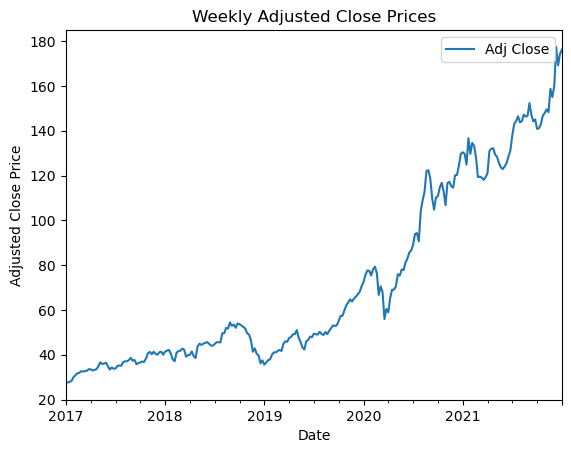

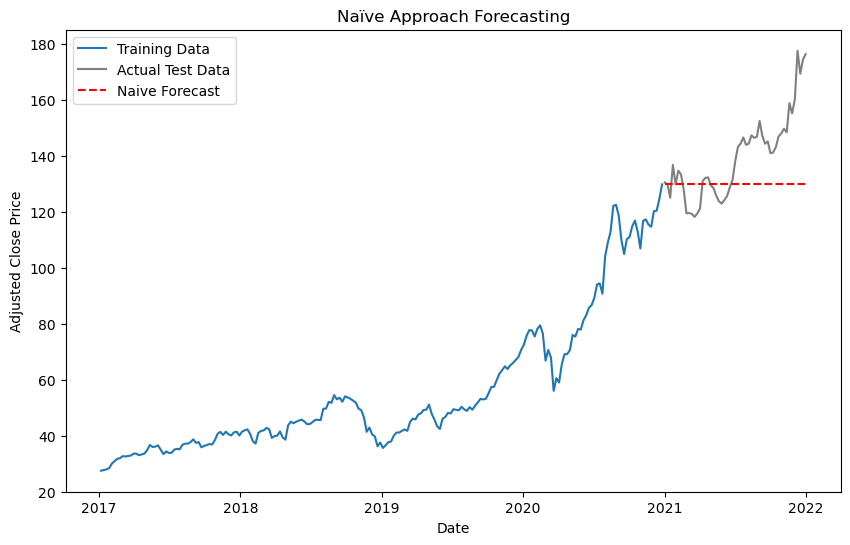

MAD: 13.16
MAPE: 8.84%
RMSE: 17.60


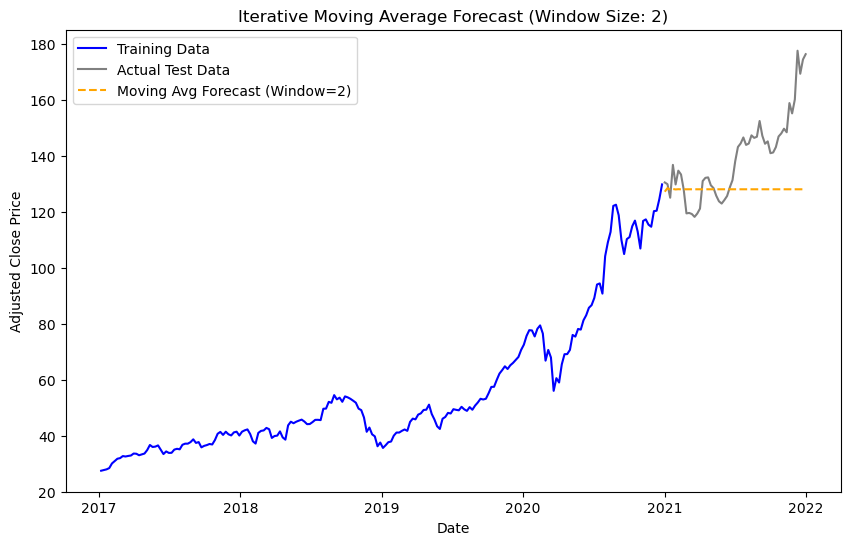

Window Size: 2
MAD: 13.94, MAPE: 9.33%, RMSE: 18.59



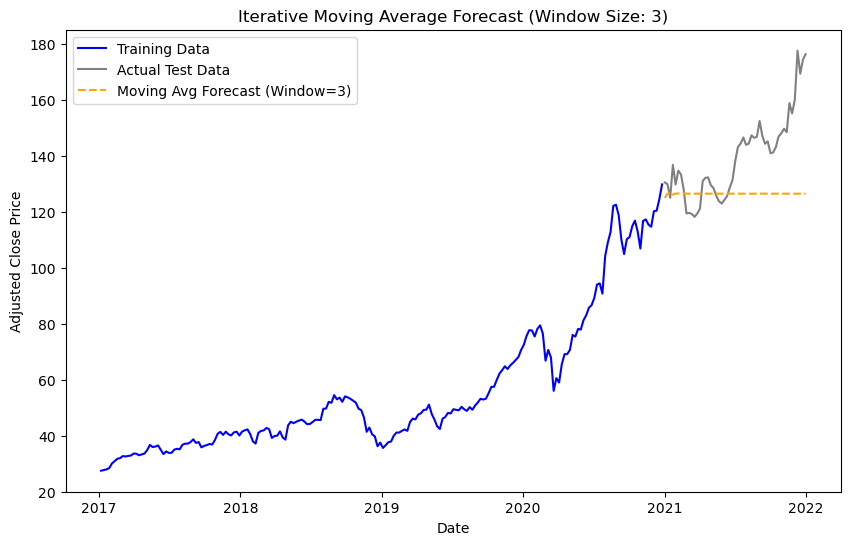

Window Size: 3
MAD: 14.84, MAPE: 9.91%, RMSE: 19.58



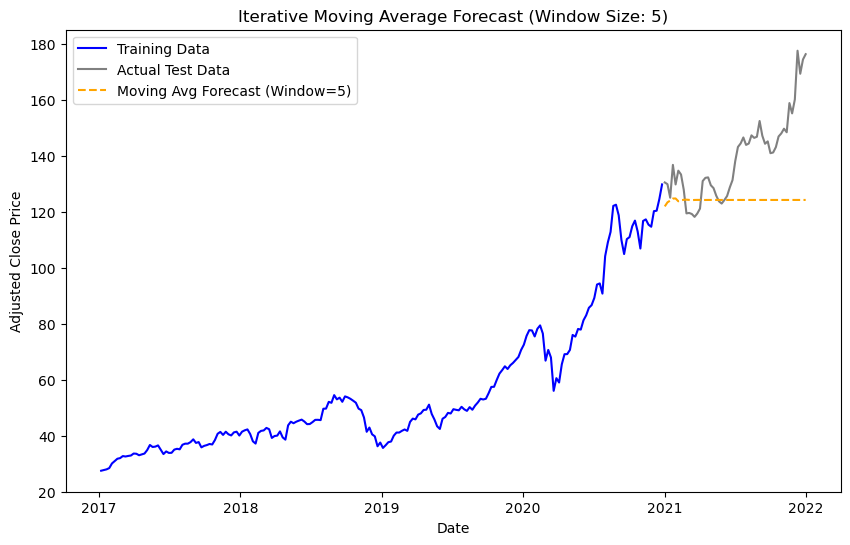

Window Size: 5
MAD: 16.22, MAPE: 10.83%, RMSE: 21.13



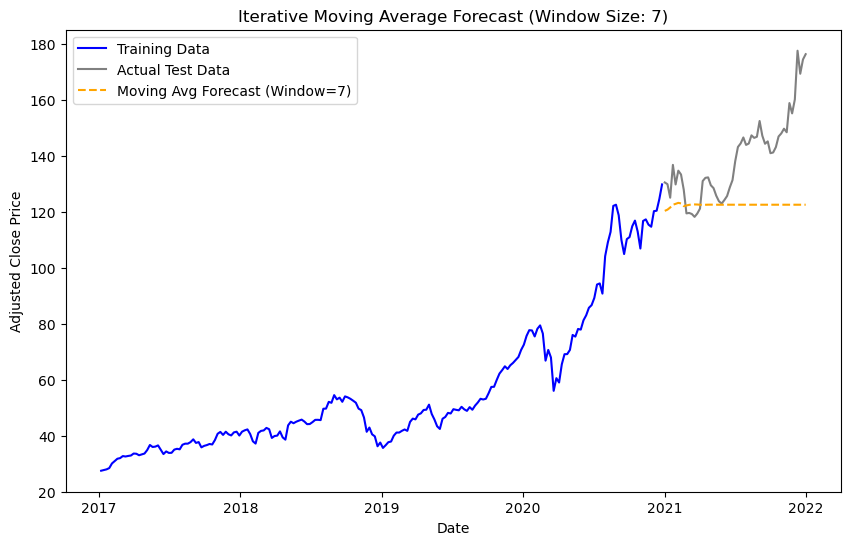

Window Size: 7
MAD: 17.48, MAPE: 11.70%, RMSE: 22.37



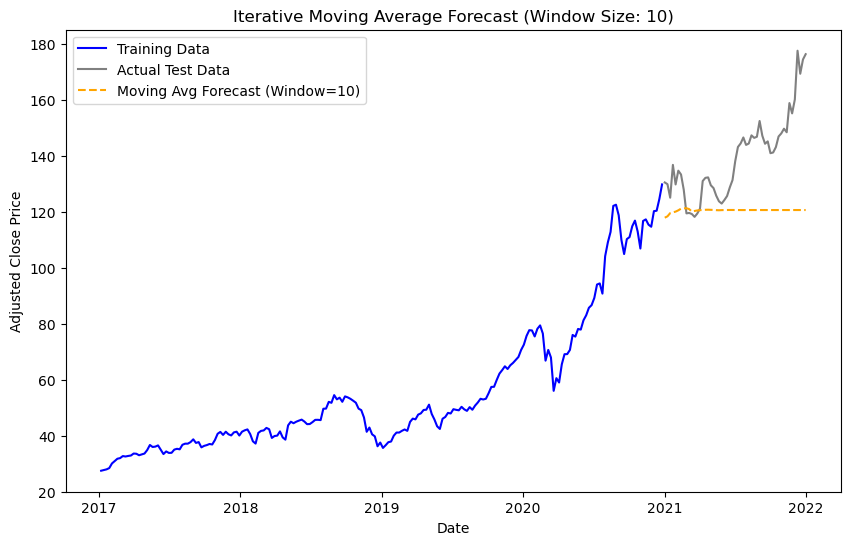

Window Size: 10
MAD: 19.01, MAPE: 12.77%, RMSE: 23.86



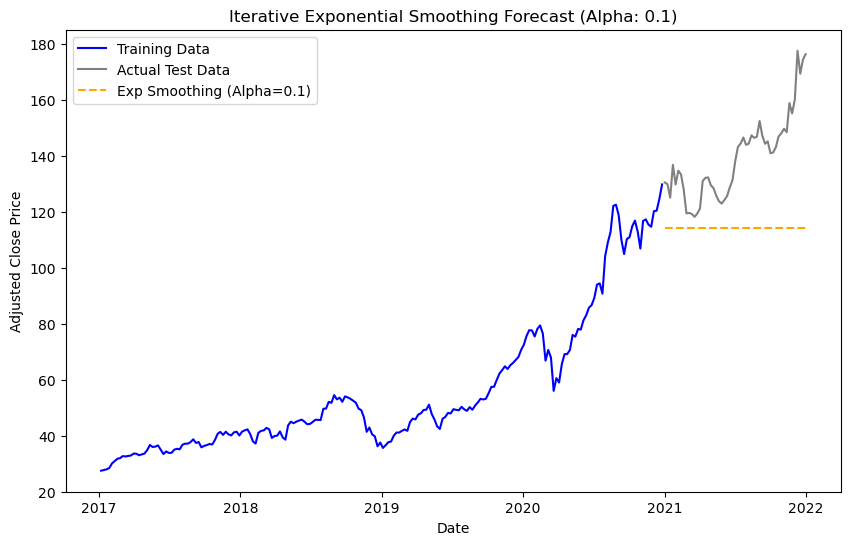

Alpha: 0.1
MAD: 25.07, MAPE: 17.13%, RMSE: 29.13



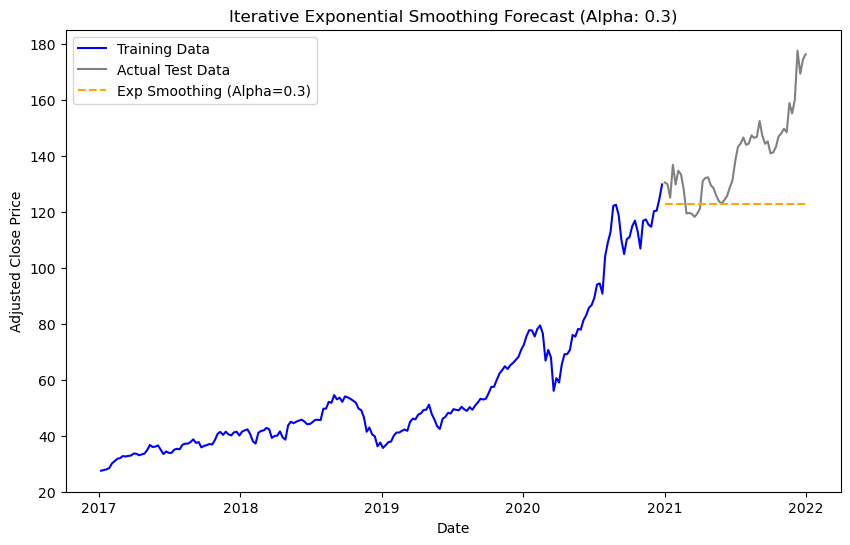

Alpha: 0.3
MAD: 17.29, MAPE: 11.56%, RMSE: 22.24



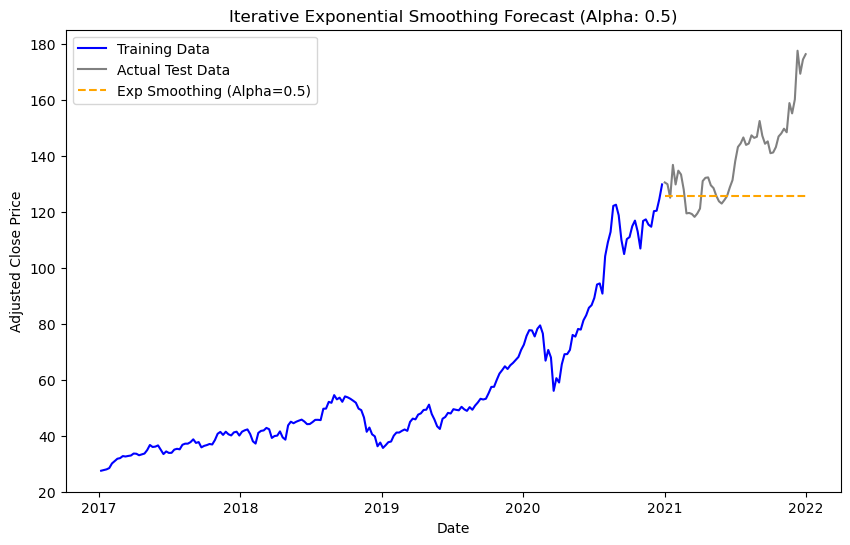

Alpha: 0.5
MAD: 15.17, MAPE: 10.12%, RMSE: 20.03



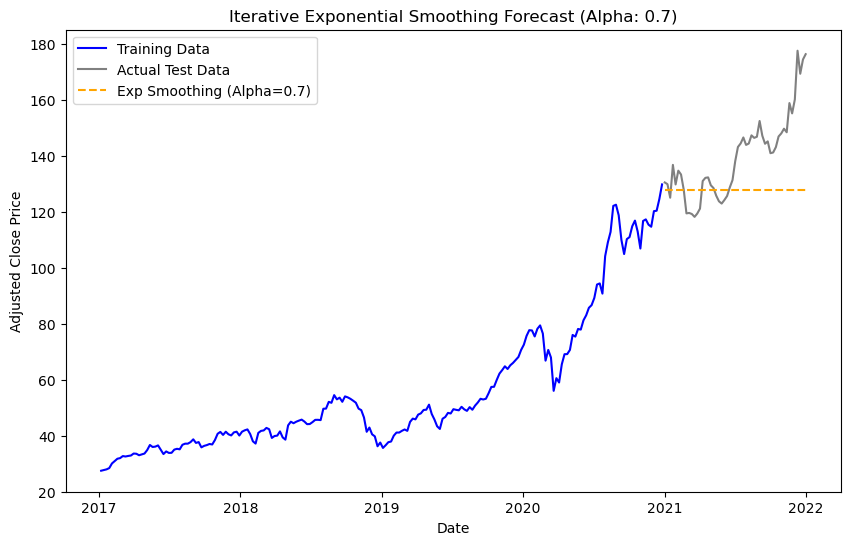

Alpha: 0.7
MAD: 14.07, MAPE: 9.41%, RMSE: 18.74



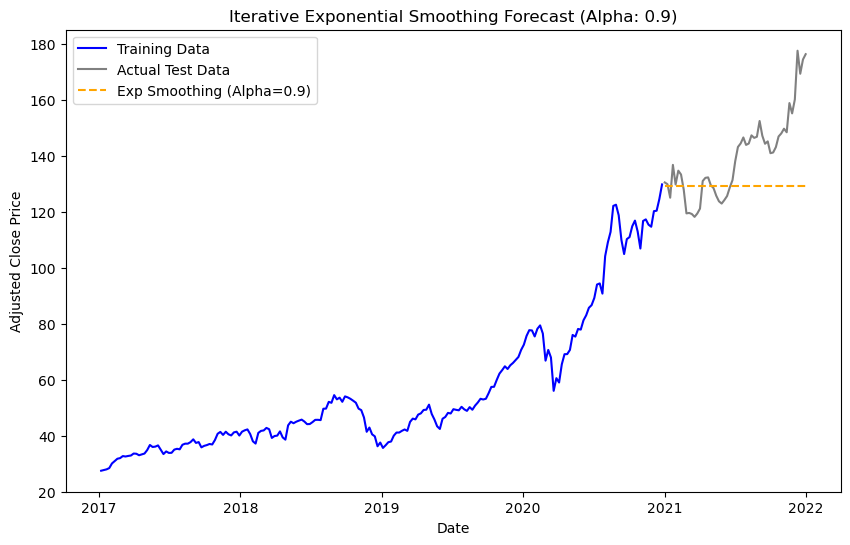

Alpha: 0.9
MAD: 13.39, MAPE: 8.98%, RMSE: 17.91



In [1]:
# Project Papadias

# A. Choose a data set of a quantity whose weekly values (e.g. closing price of a stock index every Monday) over 5 years are available. Go over this data set and make sure to clean it up of any inconsistencies, outliers, missing data, etc.

## Importing Libraries

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm

## Getting the stock price data for APPLE

# Ticker symbol for company that we want to find (e.g., 'AAPL' for Apple Inc.)
ticker_symbol = 'AAPL'

# Time Period Interval
start_time = '2017-01-01'
end_time = '2021-12-31'

stock_data = yf.download(ticker_symbol, start=start_time, end=end_time)

csv_file_path = 'stock_data.csv'
stock_data.to_csv(csv_file_path)
print(f'Stock data has been saved to {csv_file_path}')

### Separating into weekly & Preprocessing/Cleaning

file_path = 'stock_data.csv'
stock_data = pd.read_csv(file_path, index_col='Date', parse_dates=True)

weekly_data = stock_data.resample('W-FRI').agg({'Adj Close': 'last'})

# Check for missing values
cleaned_weekly_data = weekly_data.dropna()

# Drop duplicates
cleaned_weekly_data = weekly_data.drop_duplicates()

# Z-score for outlier detection
z_scores = np.abs(stats.zscore(cleaned_weekly_data['Adj Close']))
outlier_threshold = 3
outlier_indices = np.where(z_scores > outlier_threshold)
outliers = cleaned_weekly_data.iloc[outlier_indices]

print(f'Outliers:{outliers}')
print('\n')
print(cleaned_weekly_data.head())

#Saving to csv
csv_file_path = 'stock_data.csv'
cleaned_weekly_data.to_csv(csv_file_path)

cleaned_weekly_data

# Plotting the cleaned weekly data
cleaned_weekly_data.plot(title='Weekly Adjusted Close Prices')
plt.ylabel('Adjusted Close Price')
plt.show()

# B. Using the data for the first 4 years of your chosen (and cleaned up) data set, try to forecast the data of year 5. For this:

## a. Use three different forecasting techniques to perform the forecasting of level (without trend or seasonality adjustments). If a technique is parametric, try to choose the optimal value for this parameter.

## b. Compare these three techniques in two different ways.

### Naive Approach

file_path = 'stock_data.csv'
stock_data = pd.read_csv(file_path, index_col='Date', parse_dates=True)
cleaned_weekly_data = stock_data.resample('W-FRI').agg({'Adj Close': 'last'}).dropna()

train = cleaned_weekly_data[cleaned_weekly_data.index.year < 2021]
test = cleaned_weekly_data[cleaned_weekly_data.index.year == 2021]

naive_forecast = pd.DataFrame(index=test.index,columns=['Adj Close'])
naive_forecast['Adj Close'] = np.asarray(train['Adj Close'])[-1]

plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Adj Close'], label='Training Data')
plt.plot(test.index, test['Adj Close'], color='gray', label='Actual Test Data')
plt.plot(naive_forecast.index, naive_forecast['Adj Close'], color='red', linestyle='--', label='Naive Forecast')
plt.title('Naïve Approach Forecasting')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

naive_forecast = np.asarray(train['Adj Close'])[-1]
forecasted_values = np.full(len(test), naive_forecast)
mad = np.mean(np.abs(test['Adj Close'] - forecasted_values))
mape = np.mean(np.abs((test['Adj Close'] - forecasted_values) / test['Adj Close'])) * 100
rmse = np.sqrt(np.mean((test['Adj Close'] - forecasted_values) ** 2))

# Print MAD, MAPE, and RMSE
print(f'MAD: {mad:.2f}')
print(f'MAPE: {mape:.2f}%')
print(f'RMSE: {rmse:.2f}')

### Moving Average

def rmse(predictions, targets):
    return np.sqrt(mean_squared_error(predictions, targets))

# List of window sizes to try
window_sizes = [2, 3, 5, 7, 10]

for window_size in window_sizes:
    forecasted_values = []
    current_values = train['Adj Close'].tolist()

    # Iteratively forecast each point in the test set
    for i in range(len(test)):
        # Calculate the moving average with the most recent values
        if len(current_values) >= window_size:
            moving_avg = np.mean(current_values[-window_size:])
        else:
            moving_avg = np.mean(current_values)

        # Append the forecasted value and update the list for next iteration
        forecasted_values.append(moving_avg)
        current_values.append(moving_avg)

    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.plot(train.index, train['Adj Close'], label='Training Data', color='blue')
    plt.plot(test.index, test['Adj Close'], label='Actual Test Data', color='gray')
    plt.plot(test.index, forecasted_values, linestyle='--', label=f'Moving Avg Forecast (Window={window_size})', color='orange')
    plt.title(f'Iterative Moving Average Forecast (Window Size: {window_size})')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price')
    plt.legend()
    plt.show()

    # Calculate error metrics
    mad = mean_absolute_error(test['Adj Close'], forecasted_values)
    mape = np.mean(np.abs((test['Adj Close'] - forecasted_values) / test['Adj Close'])) * 100
    calculated_rmse = rmse(test['Adj Close'], forecasted_values)

    print(f'Window Size: {window_size}')
    print(f'MAD: {mad:.2f}, MAPE: {mape:.2f}%, RMSE: {calculated_rmse:.2f}\n')








### Exponential Smoothing

from statsmodels.tsa.holtwinters import SimpleExpSmoothing

alphas = [0.1, 0.3, 0.5, 0.7, 0.9]  # Different alphas to try

for alpha in alphas:
    forecasted_values = []
    current_values = train['Adj Close'].tolist()

    # Iteratively apply exponential smoothing for each point in the test set
    for i in range(len(test)):
        if i == 0:
            model = SimpleExpSmoothing(current_values).fit(smoothing_level=alpha, optimized=False)
            next_forecast = model.forecast(1)[0]
        else:
            model = SimpleExpSmoothing(current_values + forecasted_values).fit(smoothing_level=alpha, optimized=False)
            next_forecast = model.forecast(1)[0]

        forecasted_values.append(next_forecast)

    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.plot(train.index, train['Adj Close'], label='Training Data', color='blue')
    plt.plot(test.index, test['Adj Close'], label='Actual Test Data', color='gray')
    plt.plot(test.index, forecasted_values, linestyle='--', label=f'Exp Smoothing (Alpha={alpha})', color='orange')
    plt.title(f'Iterative Exponential Smoothing Forecast (Alpha: {alpha})')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price')
    plt.legend()
    plt.show()

    # Calculate error metrics
    mad = mean_absolute_error(test['Adj Close'], forecasted_values)
    mape = np.mean(np.abs((test['Adj Close'] - forecasted_values) / test['Adj Close'])) * 100
    calculated_rmse = rmse(test['Adj Close'], forecasted_values)

    print(f'Alpha: {alpha}')
    print(f'MAD: {mad:.2f}, MAPE: {mape:.2f}%, RMSE: {calculated_rmse:.2f}\n')


In [2]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.linear_model import LinearRegression
# from statsmodels.tsa.seasonal import seasonal_decompose
# from statsmodels.tsa.holtwinters import SimpleExpSmoothing
# from sklearn.metrics import mean_squared_error, mean_absolute_error

# # Assuming cleaned_weekly_data is already loaded and prepared

# # Decompose the time series to extract the trend
# decomposition = seasonal_decompose(cleaned_weekly_data['Adj Close'], model='additive', period=52)
# trend_component = decomposition.trend.dropna()

# # Find the start and end of the non-NaN trend component
# start_date = trend_component.first_valid_index()
# end_date = trend_component.last_valid_index()

# # Trim the cleaned_weekly_data to match the trend estimation period
# trimmed_data = cleaned_weekly_data.loc[start_date:end_date]

# # Prepare data for Linear Regression for trend estimation
# X = np.arange(len(trimmed_data)).reshape(-1, 1)
# y = trend_component.loc[start_date:end_date].values

# # Fit the trend model
# trend_model = LinearRegression().fit(X, y)
# trend_estimate = trend_model.predict(X)

# # Detrend the data
# detrended_data = trimmed_data['Adj Close'] - trend_estimate

# # Ensure the test data covers the entire year of 2021
# test_start_date = '2021-01-01'
# test_end_date = '2021-12-31'  # Adjust this date based on your data availability

# # Split data into training and testing sets
# train = detrended_data[:test_start_date]
# test = detrended_data[test_start_date:test_end_date]

# # Apply Exponential Smoothing to Detrended Data
# alpha = 0.3  # Adjust alpha as needed
# model = SimpleExpSmoothing(train.dropna()).fit(smoothing_level=alpha, optimized=False)
# forecast_length = len(test)
# forecast = model.forecast(forecast_length)

# # Re-integrate the trend component into the forecasted values
# trend_forecast = trend_estimate[-forecast_length:]
# adjusted_forecast = forecast.values + trend_forecast

# # Plotting the results
# plt.figure(figsize=(12, 6))
# plt.plot(trimmed_data['Adj Close'], label='Original Data', color='blue')
# plt.plot(trimmed_data.index, trend_estimate, label='Trend Component', color='green')
# plt.plot(detrended_data.index, detrended_data, label='Detrended Data', color='orange')
# plt.plot(test.index, adjusted_forecast, label='Trend-Adjusted Forecast', color='red')
# plt.title('Trend Adjustment with Exponential Smoothing')
# plt.xlabel('Date')
# plt.ylabel('Adjusted Close Price')
# plt.legend()
# plt.show()

# # Calculate error metrics for the trend-adjusted forecast
# mad = mean_absolute_error(test, adjusted_forecast)
# mape = np.mean(np.abs((test - adjusted_forecast) / test)) * 100
# rmse = np.sqrt(mean_squared_error(test, adjusted_forecast))

# print(f'Trend-Adjusted Forecast - MAD: {mad:.2f}, MAPE: {mape:.2f}%, RMSE: {rmse:.2f}')


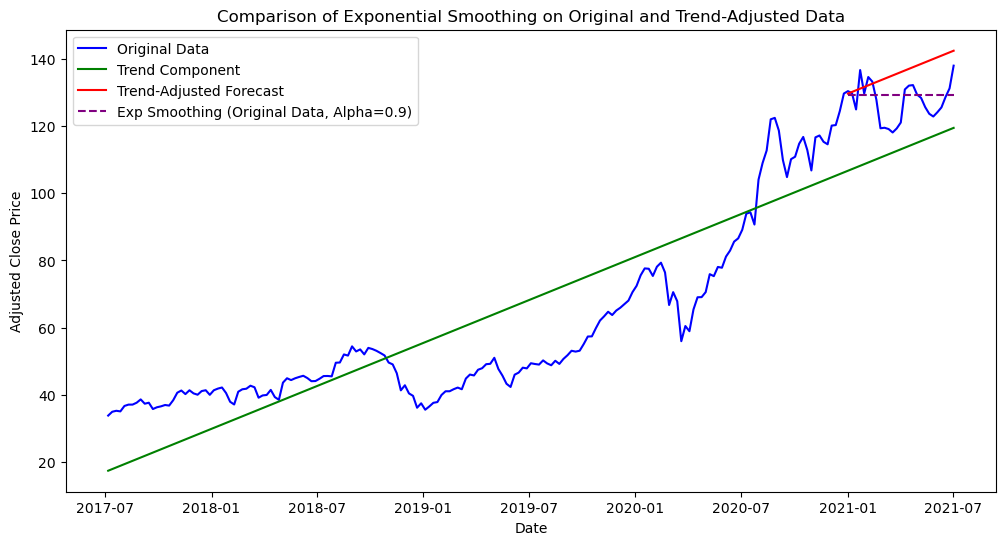

Trend-Adjusted Forecast - MAD: 9.48, MAPE: 7.62%, RMSE: 11.09


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming cleaned_weekly_data is already loaded and prepared

# Decompose the time series to extract the trend
decomposition = seasonal_decompose(cleaned_weekly_data['Adj Close'], model='additive', period=52)
trend_component = decomposition.trend.dropna()

# Find the start and end of the non-NaN trend component
start_date = trend_component.first_valid_index()
end_date = trend_component.last_valid_index()

# Trim the cleaned_weekly_data to match the trend estimation period
trimmed_data = cleaned_weekly_data.loc[start_date:end_date]

# Prepare data for Linear Regression for trend estimation
X = np.arange(len(trimmed_data)).reshape(-1, 1)
y = trend_component.loc[start_date:end_date].values

# Fit the trend model
trend_model = LinearRegression().fit(X, y)
trend_estimate = trend_model.predict(X)

# Detrend the data
detrended_data = trimmed_data['Adj Close'] - trend_estimate

# Split data into training and testing sets
train = detrended_data[:'2020-12-31']
test = detrended_data['2021-01-01':]

# Apply Exponential Smoothing to Detrended Data
alpha = 0.9  # Adjust alpha as needed
model_detrended = SimpleExpSmoothing(train.dropna()).fit(smoothing_level=alpha, optimized=False)
forecast_length = len(test)
forecast_detrended = model_detrended.forecast(forecast_length)

# Re-integrate the trend component into the forecasted values
trend_forecast = trend_estimate[-forecast_length:]
adjusted_forecast = forecast_detrended.values + trend_forecast

# Apply Exponential Smoothing to Original (Trended) Data
model_trended = SimpleExpSmoothing(trimmed_data['Adj Close'][:'2020-12-31']).fit(smoothing_level=alpha, optimized=False)
forecast_trended = model_trended.forecast(forecast_length)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(trimmed_data['Adj Close'], label='Original Data', color='blue')
plt.plot(trimmed_data.index, trend_estimate, label='Trend Component', color='green')
#plt.plot(detrended_data.index, detrended_data, label='Detrended Data', color='orange')
plt.plot(test.index, adjusted_forecast, label='Trend-Adjusted Forecast', color='red')
plt.plot(test.index, forecast_trended, linestyle='--', label=f'Exp Smoothing (Original Data, Alpha={alpha})', color='purple')  # Exponential Smoothing on Original Data
plt.title('Comparison of Exponential Smoothing on Original and Trend-Adjusted Data')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

# Calculate error metrics for the trend-adjusted forecast
mad = mean_absolute_error(test + trend_forecast, adjusted_forecast)  # Note: Adjust the test data to include the trend for MAD calculation
mape = np.mean(np.abs((test + trend_forecast - adjusted_forecast) / (test + trend_forecast))) * 100
rmse = np.sqrt(mean_squared_error(test + trend_forecast, adjusted_forecast))

print(f'Trend-Adjusted Forecast - MAD: {mad:.2f}, MAPE: {mape:.2f}%, RMSE: {rmse:.2f}')


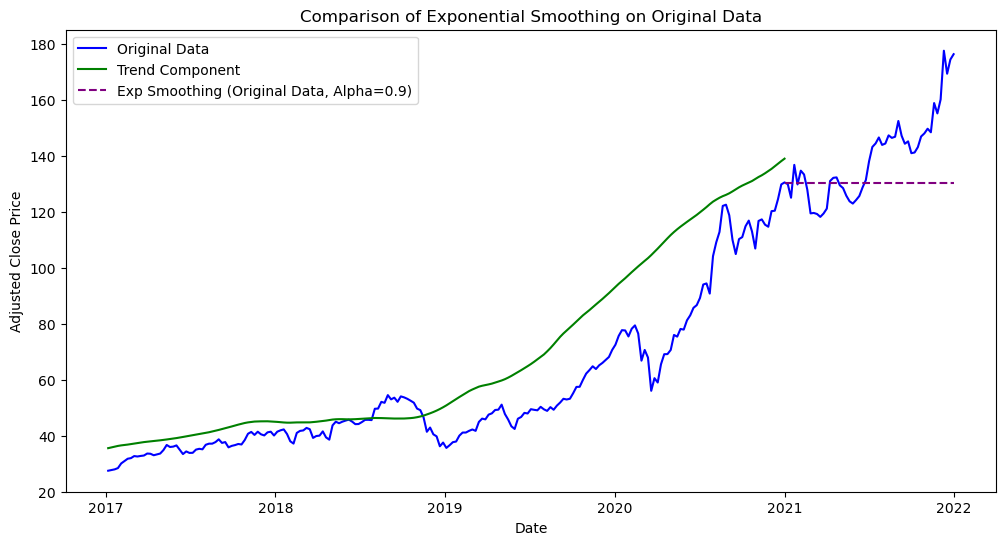

Forecast - MAD: 12.97, MAPE: 8.90%, RMSE: 17.29


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming cleaned_weekly_data is already loaded and prepared

# Decompose the time series to extract the trend
decomposition = seasonal_decompose(cleaned_weekly_data['Adj Close'], model='additive', period=52)
trend_component = decomposition.trend.dropna()

# Split data into training and testing sets
train = cleaned_weekly_data['Adj Close'][:'2021-01-01']
test = cleaned_weekly_data['Adj Close']['2021-01-01':]

# Apply Exponential Smoothing to Original (Trended) Data
alpha = 0.9  # Adjust alpha as needed
model_trended = SimpleExpSmoothing(train).fit(smoothing_level=alpha, optimized=False)
forecast_length = len(test)
forecast_trended = model_trended.forecast(forecast_length)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(cleaned_weekly_data['Adj Close'], label='Original Data', color='blue')
plt.plot(train.index, trend_component, label='Trend Component', color='green')
plt.plot(test.index, forecast_trended, linestyle='--', label=f'Exp Smoothing (Original Data, Alpha={alpha})', color='purple')  # Exponential Smoothing on Original Data
plt.title('Comparison of Exponential Smoothing on Original Data')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

# Calculate error metrics for the forecast
mad = mean_absolute_error(test, forecast_trended)
mape = np.mean(np.abs((test - forecast_trended) / test)) * 100
rmse = np.sqrt(mean_squared_error(test, forecast_trended))

print(f'Forecast - MAD: {mad:.2f}, MAPE: {mape:.2f}%, RMSE: {rmse:.2f}')


In [24]:
len(test)

53

In [19]:
train

Date
2017-01-06     27.433193
2017-01-13     27.696100
2017-01-20     27.919453
2017-01-27     28.373144
2017-02-03     30.032022
                 ...    
2020-11-27    114.566643
2020-12-04    120.128410
2020-12-11    120.285645
2020-12-18    124.461884
2020-12-25    129.679718
Freq: W-FRI, Name: Adj Close, Length: 208, dtype: float64

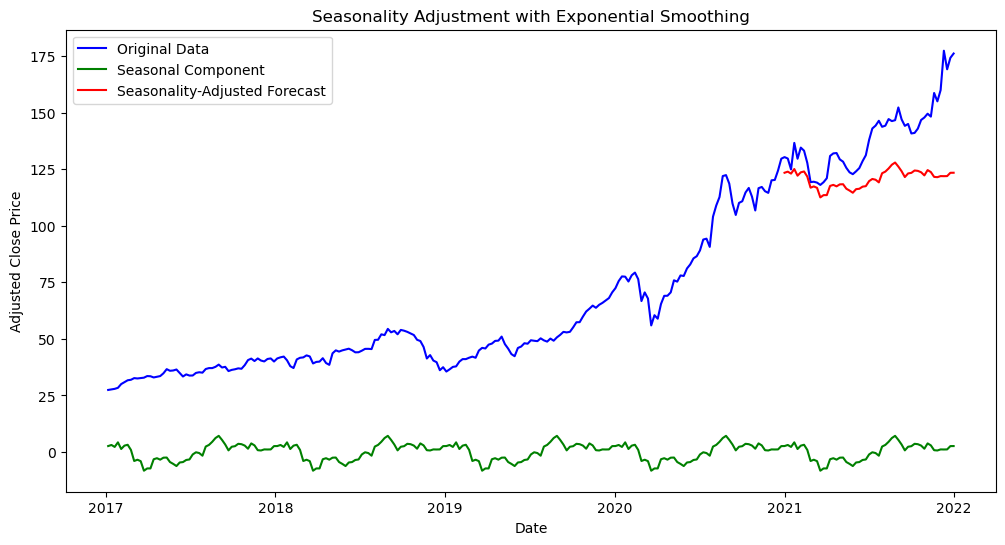

Seasonality-Adjusted Forecast - MAD: 18.22, MAPE: 12.52%, RMSE: 21.71


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming cleaned_weekly_data is already loaded and prepared

# Decompose the time series to extract trend and seasonality
decomposition = seasonal_decompose(cleaned_weekly_data['Adj Close'], model='additive', period=52)
trend_component = decomposition.trend.dropna()
seasonal_component = decomposition.seasonal.dropna()

# Deseasonalize the data by removing the seasonal component
deseasonalized_data = cleaned_weekly_data['Adj Close'] - seasonal_component

# Split data into training and testing sets for the deseasonalized data
train = deseasonalized_data[:'2020-12-31']
test = deseasonalized_data['2021-01-01':]

# Apply Exponential Smoothing to Deseasonalized Data
alpha = 0.3  # Adjust alpha as needed
model = SimpleExpSmoothing(train.dropna()).fit(smoothing_level=alpha, optimized=False)
forecast_length = len(test)
forecast_deseasonalized = model.forecast(forecast_length)

# Re-add the seasonal component to the forecasted values
seasonal_forecast = seasonal_component['2021-01-01':'2021-12-31']  # Adjust dates as needed
adjusted_forecast2 = forecast_deseasonalized.values + seasonal_forecast.values

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(cleaned_weekly_data['Adj Close'], label='Original Data', color='blue')
plt.plot(seasonal_component, label='Seasonal Component', color='green')
#plt.plot(deseasonalized_data, label='Deseasonalized Data', color='orange')
plt.plot(test.index, adjusted_forecast2, label='Seasonality-Adjusted Forecast', color='red')
plt.title('Seasonality Adjustment with Exponential Smoothing')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

# Calculate error metrics for the seasonality-adjusted forecast
mad = mean_absolute_error(test, adjusted_forecast2)
mape = np.mean(np.abs((test - adjusted_forecast2) / test)) * 100
rmse = np.sqrt(mean_squared_error(test, adjusted_forecast2))

print(f'Seasonality-Adjusted Forecast - MAD: {mad:.2f}, MAPE: {mape:.2f}%, RMSE: {rmse:.2f}')


In [11]:
adjusted_forecast2 = adjusted_forecast.values + seasonal_forecast.values
# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(cleaned_weekly_data['Adj Close'], label='Original Data', color='blue')
plt.plot(test.index, adjusted_forecast, label='Trend-Adjusted Forecast', color='red')
# plt.plot(test.index, adjusted_forecast, label='Seasonality-Adjusted Forecast', color='red')
plt.title('Seasonality Adjustment with Exponential Smoothing')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'values'

array([129.66049885, 130.15102672, 130.6415546 , 131.13208247,
       131.62261035, 132.11313822, 132.6036661 , 133.09419397,
       133.58472185, 134.07524972, 134.5657776 , 135.05630547,
       135.54683335, 136.03736122, 136.5278891 , 137.01841698,
       137.50894485, 137.99947273, 138.4900006 , 138.98052848,
       139.47105635, 139.96158423, 140.4521121 , 140.94263998,
       141.43316785, 141.92369573, 142.4142236 ])